In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

import jax.numpy as jnp
import matplotlib.pyplot as plt

import jaxley as jx
from jaxley import Compartment
from jaxley_mech.channels.benison01 import Na, Kdr, KA, KCa, CaL, CaN, CaNernstReversal, Leak, CaPumpNS
from jaxley_mech.utils import prettify

from jaxley_mech.channels.fm97 import CaPump


In [2]:
params = {
    # conductance
    "Na_gNa": 150e-3,
    "Kdr_gKdr": 75e-3,
    "KA_gKA": 50e-3,
    "KCa_gKCa": 2e-3,
    "CaL_gCaL": 2e-3,
    "CaN_gCaN": 1.5e-3,
    "Leak_gLeak": 0.25e-3,

    # reversal potential
    "Na_eNa": 75,
    "Leak_eLeak": -60,
    "eK": -85,
    "eCa": 45,

    "K_KCa": 0.6e-3,

    # pump
    "tau_store": 12.5,
    "Ceq": 0.1e-3,
    "K_pump": 0.1e-3,
    "Cao": 1.8,
    "fi": 0.025,
    # "CaPump_taur": 10.,
    # "CaPump_cainf": 0.0001,

    # global
    "length": 5.,
    "radius": 5., 
    "capacitance": 1.0,
    "axial_resistivity": 5.0,
    "v": -65,
}



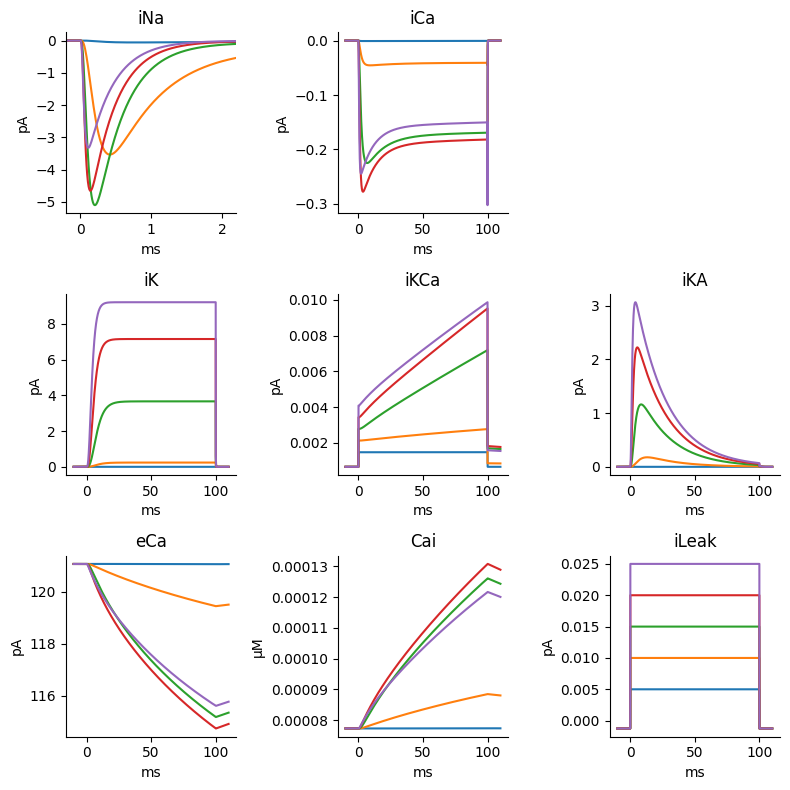

In [3]:
to_records = ["iNa", "iCa", "iK", "iKCa", "iKA", "eCa", 'Cai', "iLeak"]
mosaic = [["iNa", "iCa", "."], ["iK", "iKCa", "iKA"], ['eCa', "Cai", "iLeak"]]

fig, ax = plt.subplot_mosaic(mosaic, figsize=(8, 8))

V_steps = [-40, -20, 0, 20, 40]

# rename K currents, otherwise they will be iK

kca = KCa()
kca.current_name = "iKCa"

ka = KA()
ka.current_name = "iKA"

for v_step in V_steps:

    cell = Compartment()

    cell.insert(Na())
    cell.insert(CaN())
    cell.insert(CaL())
    cell.insert(Kdr())
    cell.insert(kca)
    cell.insert(ka)
    cell.insert(CaNernstReversal())
    cell.insert(CaPumpNS())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_statess()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_vc_time = 1000  # ms
    vc_on_time =  100 # ms
    total_time = pre_vc_time + 300 # ms
    dt = 0.01 # ms
    time_steps = int(total_time // dt + 1)
    time = jnp.linspace(0, total_time, time_steps)

    v = jnp.zeros(time_steps) - 65
    vc_on = int(pre_vc_time / dt)
    vc_off = int((pre_vc_time + vc_on_time) / dt)
    padding = int(10/dt)
    v = v.at[vc_on:vc_off].set(v_step)
    cell.clamp("v", v, verbose=False)

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)

    for i, rec in enumerate(to_records):
        ax[rec].plot((s["time"]-pre_vc_time)[vc_on-padding:vc_off+padding], s[rec][vc_on-padding:vc_off+padding])
        ax[rec].set_title(rec)
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        if rec == "Cai":
            ax[rec].set_ylabel("μM")
        elif rec== "iNa":
            ax[rec].set_xlim(-0.2, 2.2)
            ax[rec].set_ylabel("pA")
        else:
            ax[rec].set_ylabel("pA")
        
        ax[rec].set_xlabel("ms")

fig.tight_layout()

In [4]:
cell = Compartment()

cell.insert(Na())
cell.insert(CaN())
cell.insert(CaL())
cell.insert(Kdr())
cell.insert(KCa())
cell.insert(KA())
cell.insert(CaNernstReversal())
cell.insert(CaPumpNS())
cell.insert(Leak())

params = {
    # conductance
    "Na_gNa": 150e-3,
    "Kdr_gKdr": 75e-3,
    "KA_gKA": 50e-3,
    "KCa_gKCa": 2e-3,
    "CaL_gCaL": 2e-3,
    "CaN_gCaN": 1.5e-3,
    "Leak_gLeak": 0.25e-3,

    # reversal potential
    "Na_eNa": 75,
    "eK": -85,
    "eCa": 45,
    "Leak_eLeak": -60,

    "K_KCa": 0.6e-3,

    # pump
    "tau_store": 12.5,
    "Ceq": 0.1e-3,
    "K_pump": 0.1e-3,
    "Cao": 1.8,
    "fi": 0.025,

    # global
    "length": 5.,
    "radius": 5., 
    "capacitance": 10.0,
    "v": -60,
}

for name, param in params.items():
    cell.set(name, param)
    
cell.init_statess()

# Stimulus.
i_dur = 400
i_delay = 50
i_offset = 0.0
# Duration and step size.
dt = 0.01  # ms
t_max = 600  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

i_amp = 0.01  # nA
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max, i_offset=i_offset)
cell.stimulate(current, verbose=False)
to_records = ["v", "iNa", "iK", "iCa", "Cai", "eCa", "iLeak"]
for rec in to_records:
    cell.record(rec, verbose=False)

def parse_s(s, keys):
    return {key: s[i].T[:-1] for (i, key) in enumerate(keys)}

# run the model
s = jx.integrate(cell, delta_t=dt)
s = parse_s(s, to_records)

total_current = s["iNa"] + s["iK"] + s["iCa"] + s["iLeak"]

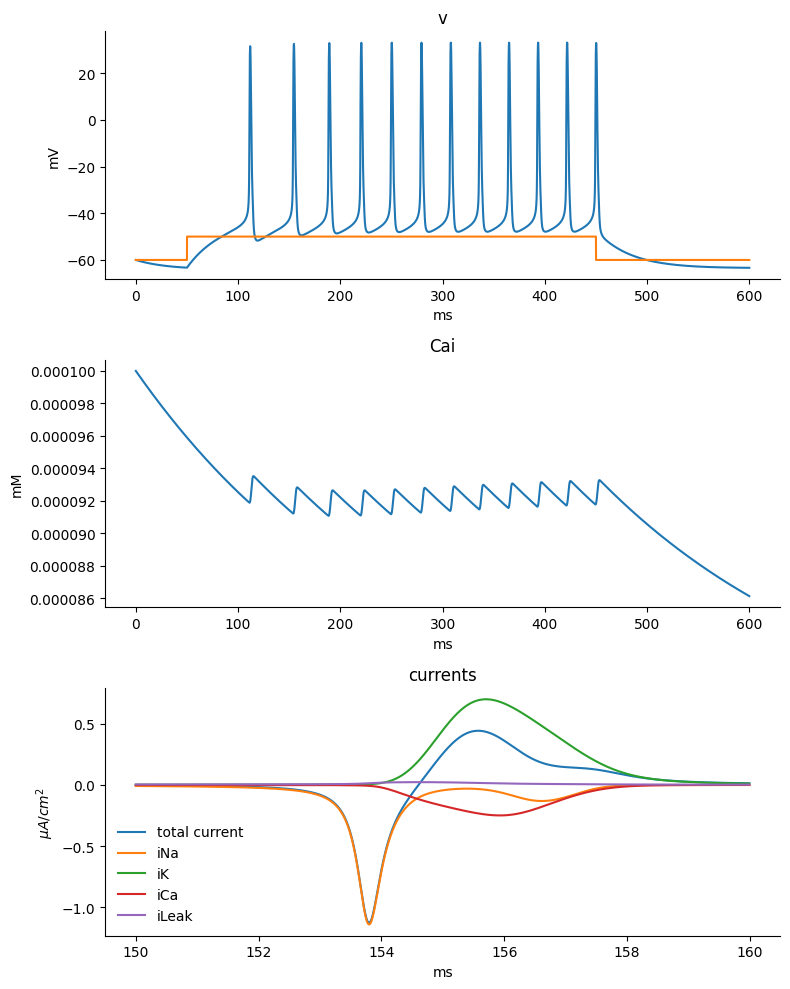

In [5]:
to_plot = ["v", "Cai", "currents"]
mosaic = [[rec] for rec in to_plot]

# figure 1
fig, ax = plt.subplot_mosaic(mosaic, figsize=(8, 10))

for key in ["v", "Cai"]:
    if key == 'Cai':
        ax[key].plot(time_vec, s[key], label=key)
        ax[key].set_ylabel("mM")
    else:
        ax[key].plot(time_vec, s[key], label=key)
        ax[key].set_ylabel("mV")
    # ax[key].set_ylabel(r"$μA/cm^2$")
    ax[key].set_xlabel("ms")
    ax[key].spines["top"].set_visible(False)
    ax[key].spines["right"].set_visible(False)
    ax[key].set_title(key)

ax["v"].plot(time_vec, (current * 1000 - 60), label="i")

ax["currents"].plot(time_vec[int(150/dt):int(160/dt)], total_current[int(150/dt):int(160/dt)], label="total current")
ax["currents"].plot(time_vec[int(150/dt):int(160/dt)], s["iNa"][int(150/dt):int(160/dt)], label="iNa")
ax["currents"].plot(time_vec[int(150/dt):int(160/dt)], s["iK"][int(150/dt):int(160/dt)], label="iK")
ax["currents"].plot(time_vec[int(150/dt):int(160/dt)], s["iCa"][int(150/dt):int(160/dt)], label="iCa")
ax["currents"].plot(time_vec[int(150/dt):int(160/dt)], s["iLeak"][int(150/dt):int(160/dt)], label="iLeak")
# ax["currents"].plot(time_vec[int(140/dt):int(160/dt)], s["iKCa"][int(140/dt):int(160/dt)], label="iKCa")
ax["currents"].spines["top"].set_visible(False)
ax["currents"].spines["right"].set_visible(False)
ax["currents"].set_title("currents")
ax["currents"].set_xlabel("ms")
ax["currents"].set_ylabel(r"$μA/cm^2$")
ax["currents"].legend(frameon=False)
fig.tight_layout()

## Notes

- Here, we only use the non-spatial calcium dynamics in this model, the spatial model is yet to be implemented.
- The rate constant of the Kdr channel in the paper is very liekly wrong, as the steady state of the gate is so different from other publications. I take the liberty to fix it.
- In the paper, the conductance of the KCa channel used the fourth power sigmoid function, which results in very small conductance changes. I use the 2nd power instead (as the one in FM97).
- The gKCa mainly controls the spike frequency. See the next figure.


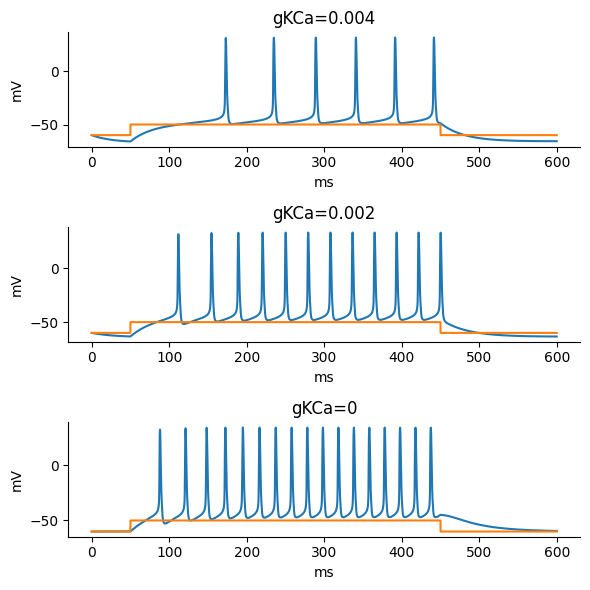

In [6]:
cell = Compartment()

cell.insert(Na())
cell.insert(CaN())
cell.insert(CaL())
cell.insert(Kdr())
cell.insert(KCa())
cell.insert(KA())
cell.insert(CaNernstReversal())
cell.insert(CaPumpNS())
cell.insert(Leak())

params = {
    # conductance
    "Na_gNa": 150e-3,
    "Kdr_gKdr": 75e-3,
    "KA_gKA": 50e-3,
    "KCa_gKCa": 2e-3,
    "CaL_gCaL": 2e-3,
    "CaN_gCaN": 1.5e-3,
    "Leak_gLeak": 0.25e-3,

    # reversal potential
    "Na_eNa": 75,
    "eK": -85,
    "eCa": 45,
    "Leak_eLeak": -60,

    "K_KCa": 0.6e-3,

    # pump
    "tau_store": 12.5,
    "Ceq": 0.1e-3,
    "K_pump": 0.1e-3,
    "Cao": 1.8,
    "fi": 0.025,

    # global
    "length": 5.,
    "radius": 5., 
    "capacitance": 10.0,
    "v": -60,
}

for name, param in params.items():
    cell.set(name, param)

# Stimulus.
i_dur = 400
i_delay = 50
i_offset = 0.0
# Duration and step size.
dt = 0.01  # ms
t_max = 600  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

i_amp = 0.01  # nA
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max, i_offset=i_offset)
cell.stimulate(current, verbose=False)  


mosaic = """
1
2
3
"""
fig, ax = plt.subplot_mosaic(mosaic, figsize=(6, 6))

for i, gkca in enumerate([4e-3, 2e-3, 0]):

    cell.set("KCa_gKCa", gkca)
    cell.init_statess()

    cell.record("v", verbose=False)

    # run the model
    s = jx.integrate(cell, delta_t=dt)
    s = parse_s(s, ["v"])

    ax[str(i+1)].plot(time_vec, s["v"], label=key)
    ax[str(i+1)].set_ylabel("mV")
    ax[str(i+1)].set_xlabel("ms")
    ax[str(i+1)].spines["top"].set_visible(False)
    ax[str(i+1)].spines["right"].set_visible(False)
    ax[str(i+1)].set_title(f"gKCa={gkca}")

    ax[str(i+1)].plot(time_vec, (current * 1000 - 60), label="i")

fig.tight_layout()


In [7]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-10-23 20:17:03CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.2.1

jax       : 0.4.35
jaxley    : 0.4.0
matplotlib: 3.9.2

Watermark: 2.4.3

